# **Classification using Logistic Regression**
Nauman Ali Murad - 2022479

In [ ]:
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
# Flatten the label arrays
y_train = y_train.flatten()
y_test = y_test.flatten()

# Filter for cats and dogs
train_filter = (y_train == 3) | (y_train == 5)
test_filter = (y_test == 3) | (y_test == 5)

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Resize images to 32x32 (choose any size that works for your model)
x_train = tf.image.resize(x_train, [32, 32])
x_test = tf.image.resize(x_test, [32, 32])

x_train = tf.image.rgb_to_grayscale(x_train)
x_test = tf.image.rgb_to_grayscale(x_test)

In [ ]:
# Normalize the pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Change labels to 0 and 1 (0 for cats, 1 for dogs)
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

In [ ]:
def apply_sobel_edge_detection(image_batch):
    # Sobel filters for x and y direction
    sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32)
    sobel_y = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32)

    # Expand dimensions to fit the 4D requirement of conv2d: [height, width, in_channels, out_channels]
    sobel_x_filter = tf.reshape(sobel_x, [3, 3, 1, 1])
    sobel_y_filter = tf.reshape(sobel_y, [3, 3, 1, 1])

    # Ensure the input is 4D
    if len(image_batch.shape) < 4:
        image_batch = tf.expand_dims(image_batch, -1)  # Add a channel dimension if not present

    if image_batch.shape[-1] == 3:  # If RGB, convert to grayscale
        image_batch = tf.image.rgb_to_grayscale(image_batch)

    filtered_x = tf.nn.conv2d(input=image_batch, filters=sobel_x_filter, strides=[1, 1, 1, 1], padding='SAME')
    filtered_y = tf.nn.conv2d(input=image_batch, filters=sobel_y_filter, strides=[1, 1, 1, 1], padding='SAME')

    sobel_output = tf.sqrt(tf.square(filtered_x) + tf.square(filtered_y))

    sobel_output = tf.reshape(sobel_output, [sobel_output.shape[0], -1])

    return sobel_output

x_train_edges = apply_sobel_edge_detection(x_train)
x_test_edges = apply_sobel_edge_detection(x_test)

x_train_edges = x_train_edges / tf.reduce_max(x_train_edges)
x_test_edges = x_test_edges / tf.reduce_max(x_test_edges)

In [ ]:
# Model setup
model = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence

# Train the model
model.fit(x_train_edges, y_train)

# Evaluate the model on the test set
test_accuracy = model.score(x_test_edges, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Interpret the Logistic Regression coefficients
coefficients = model.coef_[0]  # Get the coefficients for the features
# Display some of the highest and lowest coefficients to see which features weigh more
most_positive = np.argsort(coefficients)[-10:]  # Indices of the 10 most positive coefficients
most_negative = np.argsort(coefficients)[:10]  # Indices of the 10 most negative coefficients

print("Features with most positive influence on predicting dogs:")
print(most_positive)
print("Features with most negative influence on predicting cats:")
print(most_negative)

Test accuracy: 0.59
Features with most positive influence on predicting dogs:
[1006  232  275  229  738  399  707  826  619  363]
Features with most negative influence on predicting cats:
[ 903  618  967   26  991  245  571  641  104 1019]


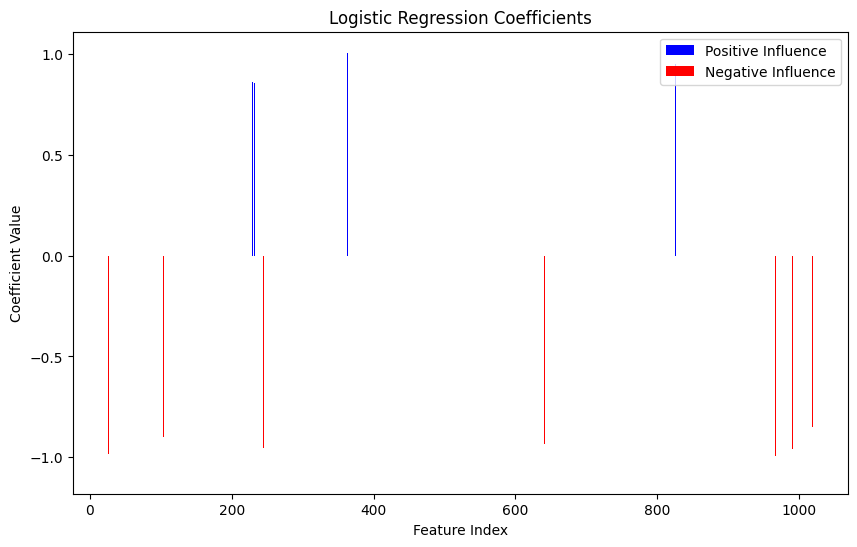

In [ ]:
feature_names = np.arange(x_train_edges.shape[1])

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.bar(feature_names[most_positive], coefficients[most_positive], color='b', label='Positive Influence')
plt.bar(feature_names[most_negative], coefficients[most_negative], color='r', label='Negative Influence')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.legend()
plt.show()


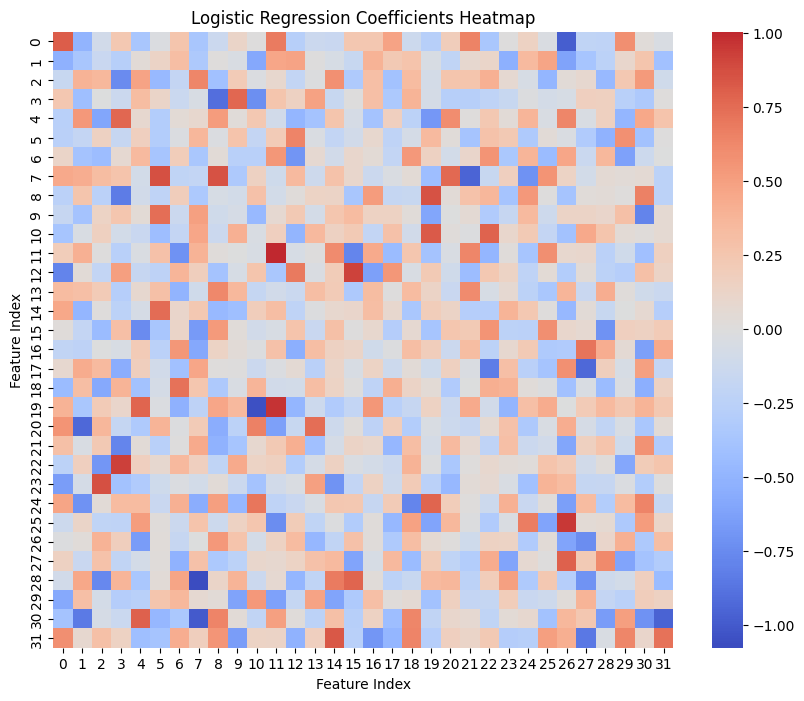

In [ ]:
coefficients_reshaped = coefficients.reshape(32, 32)

plt.figure(figsize=(10, 8))
sns.heatmap(coefficients_reshaped, cmap='coolwarm', center=0)
plt.title('Logistic Regression Coefficients Heatmap')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.show()